In [1]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [4]:
x_train , x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
x_val = x_val.astype('float32')

In [5]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))
print(len(x_val))
print(len(y_val))

40000
40000
10000
10000
10000
10000


In [6]:
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))

x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
x_val = (x_val-mean)/(std+1e-7)


In [7]:
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)
y_val = np_utils.to_categorical(y_val,num_classes)

In [8]:
weight_decay = 1e-4

In [9]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [10]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [11]:
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger,ReduceLROnPlateau,LearningRateScheduler,EarlyStopping
mc = ModelCheckpoint('Ciphar_Adam_elu_Add_Depth_5.h5', monitor='val_loss', save_best_only=True)
tb = TensorBoard(log_dir='./logs', write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, update_freq='epoch')
cv = CSVLogger('Ciphar_Adam_elu_Add_Depth_5.csv',append=True)
rp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [12]:
batch_size = 64

opt_rms = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True) 

model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=200,validation_data=(x_val,y_val),
                    class_weight='auto',verbose=1,callbacks=[LearningRateScheduler(lr_schedule),mc,cv,tb,rp,es])

Epoch 1/200
625/625 [==============================] - 22s 35ms/step - loss: 2.4776 - acc: 0.3167 - val_loss: 1.8760 - val_acc: 0.4035
Epoch 2/200
625/625 [==============================] - 19s 31ms/step - loss: 2.1643 - acc: 0.3681 - val_loss: 1.7761 - val_acc: 0.4248
Epoch 3/200
625/625 [==============================] - 19s 31ms/step - loss: 2.1200 - acc: 0.3814 - val_loss: 2.0333 - val_acc: 0.3636
Epoch 4/200
625/625 [==============================] - 19s 31ms/step - loss: 2.0126 - acc: 0.4214 - val_loss: 2.8250 - val_acc: 0.3789
Epoch 5/200
625/625 [==============================] - 19s 31ms/step - loss: 1.9395 - acc: 0.4436 - val_loss: 1.7760 - val_acc: 0.4572
Epoch 6/200
625/625 [==============================] - 19s 31ms/step - loss: 1.9052 - acc: 0.4665 - val_loss: 1.7814 - val_acc: 0.4886
Epoch 7/200
625/625 [==============================] - 20s 31ms/step - loss: 1.9096 - acc: 0.4713 - val_loss: 2.0790 - val_acc: 0.4305
Epoch 8/200
625/625 [==============================] - 

625/625 [==============================] - 19s 31ms/step - loss: 0.8119 - acc: 0.8101 - val_loss: 0.7273 - val_acc: 0.8424
Epoch 62/200
625/625 [==============================] - 19s 31ms/step - loss: 0.8066 - acc: 0.8121 - val_loss: 0.7475 - val_acc: 0.8369
Epoch 63/200
625/625 [==============================] - 19s 31ms/step - loss: 0.8042 - acc: 0.8112 - val_loss: 0.7525 - val_acc: 0.8336
Epoch 64/200
625/625 [==============================] - 19s 31ms/step - loss: 0.7973 - acc: 0.8121 - val_loss: 0.7263 - val_acc: 0.8381
Epoch 65/200
625/625 [==============================] - 19s 31ms/step - loss: 0.7993 - acc: 0.8128 - val_loss: 0.7414 - val_acc: 0.8333
Epoch 66/200
625/625 [==============================] - 19s 31ms/step - loss: 0.7908 - acc: 0.8145 - val_loss: 0.7544 - val_acc: 0.8311
Epoch 67/200
625/625 [==============================] - 19s 31ms/step - loss: 0.7856 - acc: 0.8172 - val_loss: 0.7460 - val_acc: 0.8366
Epoch 68/200
625/625 [==============================] - 19s 3

625/625 [==============================] - 20s 31ms/step - loss: 0.5128 - acc: 0.8843 - val_loss: 0.5498 - val_acc: 0.8807
Epoch 122/200
625/625 [==============================] - 19s 31ms/step - loss: 0.5089 - acc: 0.8862 - val_loss: 0.5578 - val_acc: 0.8792
Epoch 123/200
625/625 [==============================] - 19s 31ms/step - loss: 0.5089 - acc: 0.8863 - val_loss: 0.5611 - val_acc: 0.8781
Epoch 124/200
625/625 [==============================] - 19s 31ms/step - loss: 0.5127 - acc: 0.8837 - val_loss: 0.5414 - val_acc: 0.8832
Epoch 125/200
625/625 [==============================] - 19s 31ms/step - loss: 0.5055 - acc: 0.8881 - val_loss: 0.5455 - val_acc: 0.8826
Epoch 126/200
625/625 [==============================] - 19s 31ms/step - loss: 0.5032 - acc: 0.8873 - val_loss: 0.5595 - val_acc: 0.8787
Epoch 127/200
625/625 [==============================] - 19s 31ms/step - loss: 0.5031 - acc: 0.8874 - val_loss: 0.5407 - val_acc: 0.8834
Epoch 128/200
625/625 [==============================] 

Epoch 181/200
625/625 [==============================] - 19s 31ms/step - loss: 0.4583 - acc: 0.9006 - val_loss: 0.5486 - val_acc: 0.8817
Epoch 182/200
625/625 [==============================] - 19s 31ms/step - loss: 0.4531 - acc: 0.9032 - val_loss: 0.5230 - val_acc: 0.8909
Epoch 183/200
625/625 [==============================] - 19s 31ms/step - loss: 0.4592 - acc: 0.8995 - val_loss: 0.5287 - val_acc: 0.8890
Epoch 184/200
625/625 [==============================] - 19s 31ms/step - loss: 0.4525 - acc: 0.9027 - val_loss: 0.5268 - val_acc: 0.8874
Epoch 185/200
625/625 [==============================] - 19s 31ms/step - loss: 0.4535 - acc: 0.9013 - val_loss: 0.5408 - val_acc: 0.8850
Epoch 186/200
625/625 [==============================] - 20s 31ms/step - loss: 0.4618 - acc: 0.8972 - val_loss: 0.5398 - val_acc: 0.8829
Epoch 187/200
625/625 [==============================] - 19s 31ms/step - loss: 0.4561 - acc: 0.9003 - val_loss: 0.5370 - val_acc: 0.8837
Epoch 188/200
625/625 [==================

In [13]:
test_loss,test_acc=model.evaluate(x_test,y_test)
print(test_loss)
print(test_acc)

10000/10000 [==============================] - 2s 221us/step
0.5541714966773987
0.8823


In [14]:
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
xc=range(200)

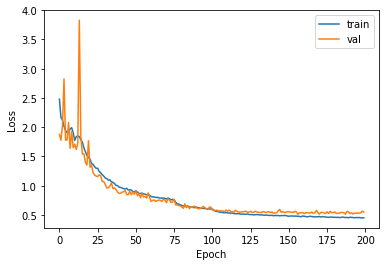

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

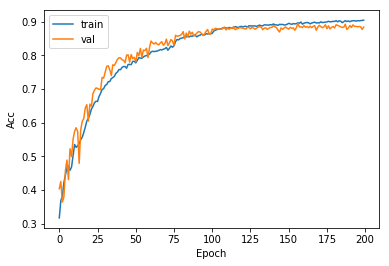

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

In [ ]:
pred=model.predict(x_test[0].reshape(1,32,32,3))
print(pred)
print(pred.argmax())

In [ ]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['class 0', 'class 1', 'class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))

In [ ]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    acc=np.trace(cm)/float(np.sum(cm))
    miss_class=1-acc
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print(acc)
    print(miss_class)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')